In [16]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import datasets, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, random_split ,Subset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
folder_path = "/kaggle/input/antenna/final_Copy"

print("Path to dataset files:", folder_path)

Path to dataset files: /kaggle/input/antenna/final_Copy


In [5]:
dataset0 = datasets.ImageFolder(root=folder_path)
print("Class to index mapping",dataset0.class_to_idx)
print("Total number of pictures ",len(dataset0))

Class to index mapping {'Airtel': 0, 'Dish_Tv': 1, 'Sun_Direct': 2, 'Tata_Sky': 3, 'Videocon_d2h': 4}
Total number of pictures  3048


In [6]:
convert_to_tensor_transform = transforms.Compose(
    [transforms.Resize((256, 256)),
    transforms.ToTensor()])
dataset_for_stats = datasets.ImageFolder(root=folder_path,transform=convert_to_tensor_transform)
loader = DataLoader(dataset_for_stats,batch_size=32,num_workers=2)
class_names = ['Airtel', 'Dish_Tv', 'Sun_Direct', 'Tata_Sky', 'Videocon_d2h']

In [7]:
channels_sum = torch.zeros(3)
channels_squared_sum = torch.zeros(3)
total_pixels = 0

for images,_ in loader:
  assert isinstance(images,torch.Tensor)
  assert images.ndim == 4
  assert images.shape[1] == 3

  channels_sum += images.sum(dim=[0,2,3])
  channels_squared_sum += (images**2).sum(dim=[0,2,3])
  total_pixels += images.size(0)*images.size(2)*images.size(3)

In [8]:
mean = channels_sum / total_pixels
standard_deviation = ((channels_squared_sum / total_pixels) - (mean)**2)**0.5

print("channel specific mean are ",mean)
print("channel specific standard deviation is ",standard_deviation)

channel specific mean are  tensor([0.4525, 0.4486, 0.4502])
channel specific standard deviation is  tensor([0.3757, 0.3736, 0.3770])


In [9]:
mean = torch.tensor([0.4525, 0.4486, 0.4502])
standard_deviation = torch.tensor([0.3757, 0.3736, 0.3770])

In [10]:
pixel_normalizer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=standard_deviation)
])

In [11]:
normalized_dataset = datasets.ImageFolder(root=folder_path,transform=pixel_normalizer_transform)
normalized_loader = DataLoader(normalized_dataset,batch_size=64,shuffle=True,num_workers=2)

images , labels = next(iter(normalized_loader))
if not isinstance(images, torch.Tensor):
    raise AssertionError("Images are not torch tensors")

if not isinstance(images, torch.Tensor):
    raise AssertionError("Images are not torch tensors")

print("image batch shape",images.shape)
print("label batch shape",labels.shape)

image batch shape torch.Size([64, 3, 256, 256])
label batch shape torch.Size([64])


In [12]:
## train dev test split version

total_size = len(normalized_dataset)
test_size = int(0.1 * total_size)
dev_size = int(0.1 * total_size)
train_size = total_size - test_size - dev_size


train_dataset, dev_dataset, test_dataset = random_split(
    normalized_dataset, [train_size, dev_size, test_size]
)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
dev_loader   = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [13]:
def build_vgg16_transfer_model(num_classes=5):
    # Load pretrained VGG16
    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

    # Freeze all parameters
    for param in vgg16.parameters():
        param.requires_grad = False

    # Replace only the final classifier layer
    # Keep the rest of the classifier frozen
    vgg16.classifier[6] = nn.Linear(4096, num_classes)

    # Only the last layer is trainable
    for param in vgg16.classifier[6].parameters():
        param.requires_grad = True

    return vgg16


In [14]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, train_losses, train_accuracies):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Logging
        batch_loss = running_loss / total
        batch_accuracy = 100 * correct / total
        train_losses.append(batch_loss)
        train_accuracies.append(batch_accuracy)

        print(f"[Batch {batch_idx}] Loss: {batch_loss:.4f} | Accuracy: {batch_accuracy:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_vgg16_transfer_model(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-3, weight_decay=1e-4, betas=(0.9, 0.999))

train_losses, train_accuracies = [], []
num_epochs = int(input("Enter number of epochs: "))
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, train_losses, train_accuracies)


Enter number of epochs:  8



Epoch 1/8
[Batch 0] Loss: 1.7018 | Accuracy: 23.44%
[Batch 1] Loss: 1.7106 | Accuracy: 27.73%
[Batch 2] Loss: 1.6619 | Accuracy: 33.33%
[Batch 3] Loss: 1.7316 | Accuracy: 35.55%
[Batch 4] Loss: 1.6077 | Accuracy: 40.62%
[Batch 5] Loss: 1.4862 | Accuracy: 44.92%
[Batch 6] Loss: 1.4197 | Accuracy: 46.88%
[Batch 7] Loss: 1.3737 | Accuracy: 49.02%
[Batch 8] Loss: 1.3119 | Accuracy: 51.39%
[Batch 9] Loss: 1.2398 | Accuracy: 53.75%
[Batch 10] Loss: 1.1943 | Accuracy: 55.18%
[Batch 11] Loss: 1.1503 | Accuracy: 56.90%
[Batch 12] Loss: 1.1068 | Accuracy: 58.35%
[Batch 13] Loss: 1.0674 | Accuracy: 59.49%
[Batch 14] Loss: 1.0412 | Accuracy: 60.68%
[Batch 15] Loss: 1.0091 | Accuracy: 62.30%
[Batch 16] Loss: 0.9842 | Accuracy: 63.33%
[Batch 17] Loss: 0.9576 | Accuracy: 64.45%
[Batch 18] Loss: 0.9319 | Accuracy: 65.46%
[Batch 19] Loss: 0.9317 | Accuracy: 65.49%

Epoch 2/8
[Batch 0] Loss: 0.5719 | Accuracy: 79.69%
[Batch 1] Loss: 0.5249 | Accuracy: 79.30%
[Batch 2] Loss: 0.5211 | Accuracy: 79.95%
[B

In [20]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_preds, all_labels


In [21]:
train_loss, train_acc, train_preds, train_labels = evaluate_model(model, train_loader, criterion, device)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

dev_loss, dev_acc, dev_preds, dev_labels = evaluate_model(model, dev_loader, criterion, device)
print(f"Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_acc:.2f}%")

test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Train Loss: 0.0343, Train Accuracy: 99.59%
Dev Loss: 0.0689, Dev Accuracy: 99.01%
Test Loss: 0.0922, Test Accuracy: 98.03%


In [23]:
def plot_precision_recall_f1(train_preds, train_labels, dev_preds, dev_labels, test_preds, test_labels, average='macro'):

    datasets = {
        "Train": (train_labels, train_preds),
        "Dev":   (dev_labels, dev_preds),
        "Test":  (test_labels, test_preds)
    }

    precision_scores = []
    recall_scores = []
    f1_scores = []

    print(" Precision, Recall, and F1 Scores (Average = '{}'):\n".format(average))
    for name, (true, pred) in datasets.items():
        precision = precision_score(true, pred, average=average)
        recall = recall_score(true, pred, average=average)
        f1 = f1_score(true, pred, average=average)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"{name} Set:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}\n")

    x = np.arange(len(datasets))
    width = 0.25

    plt.figure(figsize=(9, 6))
    plt.bar(x - width, precision_scores, width, label='Precision')
    plt.bar(x, recall_scores, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1 Score')

    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score by Dataset')
    plt.xticks(x, list(datasets.keys()))
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


 Precision, Recall, and F1 Scores (Average = 'macro'):

Train Set:
  Precision: 0.9960
  Recall:    0.9960
  F1-Score:  0.9960

Dev Set:
  Precision: 0.9899
  Recall:    0.9903
  F1-Score:  0.9900

Test Set:
  Precision: 0.9823
  Recall:    0.9810
  F1-Score:  0.9814



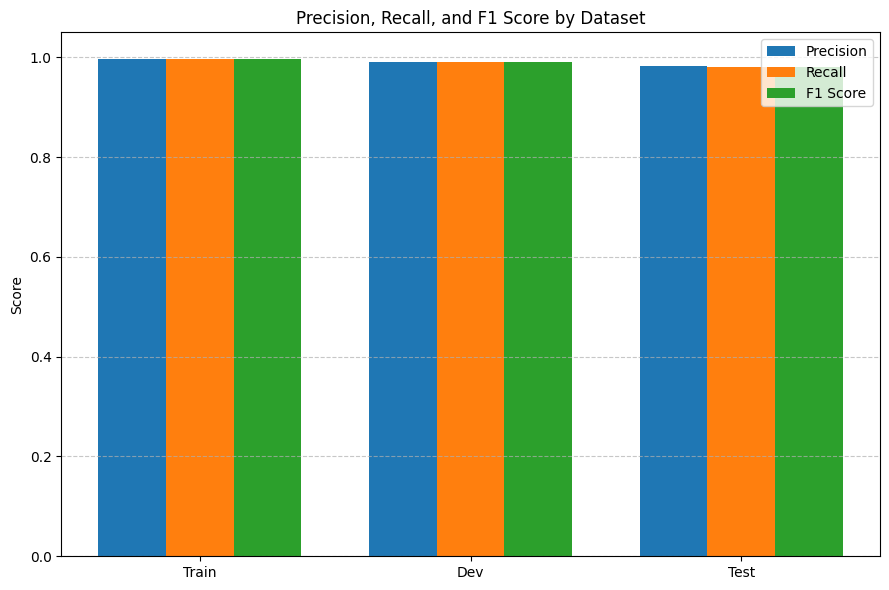

In [26]:
plot_precision_recall_f1(train_preds, train_labels, dev_preds, dev_labels, test_preds, test_labels)

In [27]:
def plot_confusion_matrices(dev_preds, dev_labels, test_preds, test_labels, class_names=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    cm_dev = confusion_matrix(dev_labels, dev_preds)
    cm_test = confusion_matrix(test_labels, test_preds)

    ConfusionMatrixDisplay(cm_dev, display_labels=class_names).plot(ax=axs[0], values_format='d')
    axs[0].set_title('Dev Set Confusion Matrix')

    ConfusionMatrixDisplay(cm_test, display_labels=class_names).plot(ax=axs[1], values_format='d')
    axs[1].set_title('Test Set Confusion Matrix')

    plt.tight_layout()
    plt.show()


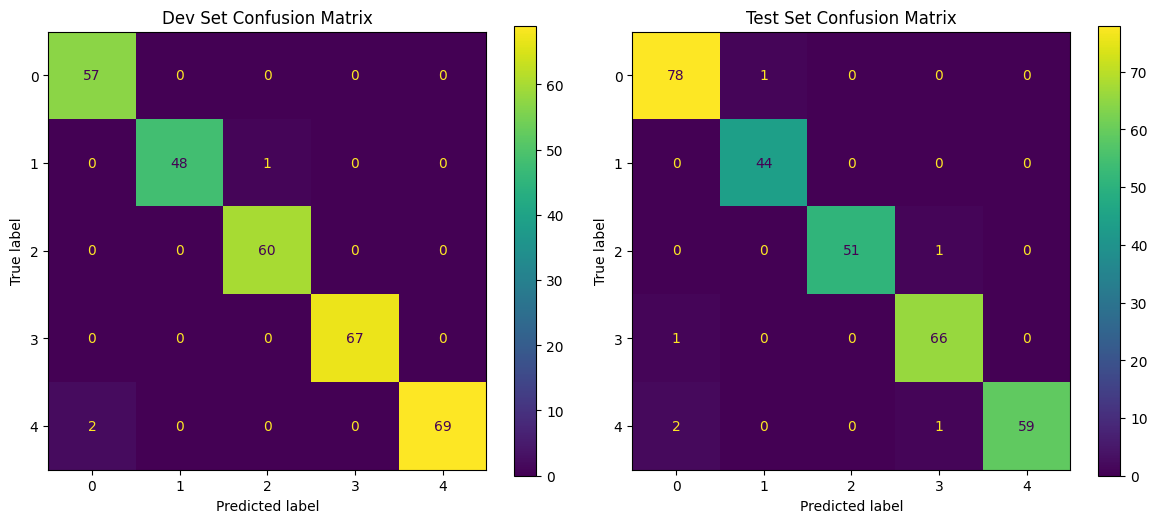

In [28]:
plot_confusion_matrices(dev_preds, dev_labels, test_preds, test_labels,)

In [29]:
def plot_loss_accuracy(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axis sharing the same x-axis
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(epochs, train_accuracies, label='Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title("Training Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()

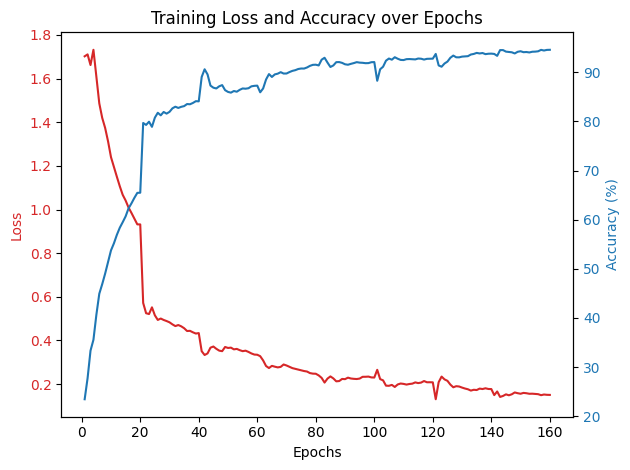

In [30]:
plot_loss_accuracy(train_losses, train_accuracies)

In [31]:

def show_random_predictions(model, dataset, class_names, device, num_samples=5):
    model.eval()
    model.to(device)

    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    images, labels = zip(*samples)
    images_tensor = torch.stack(images).to(device)
    labels_tensor = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images_tensor)
        _, preds = torch.max(outputs, 1)

    # Plotting the images with predictions
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_names[preds[i]]}, Actual: {class_names[labels_tensor[i]]}")
        plt.show()

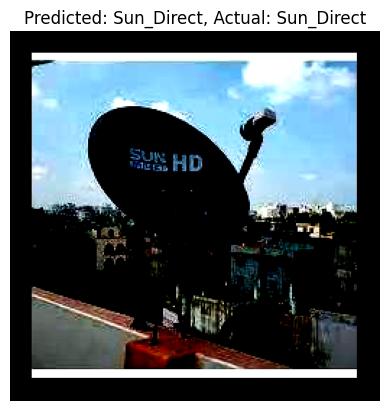

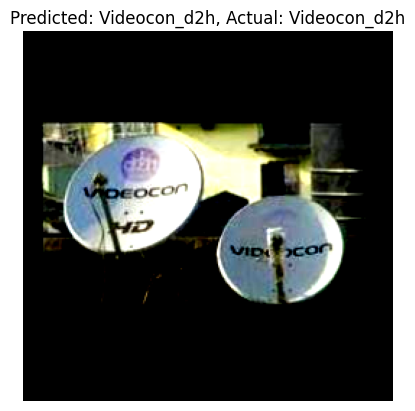

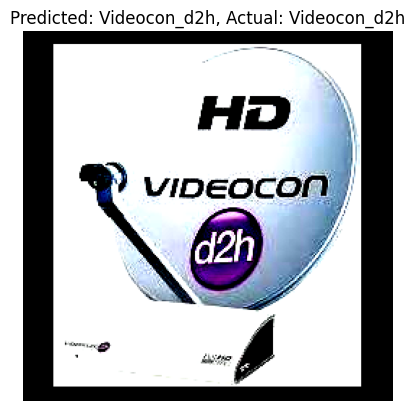

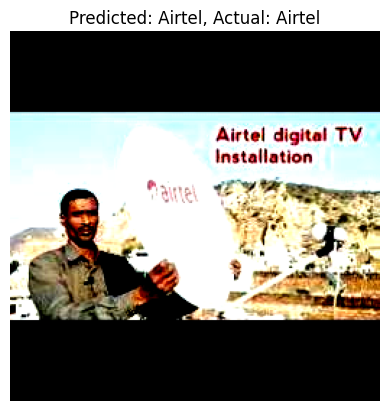

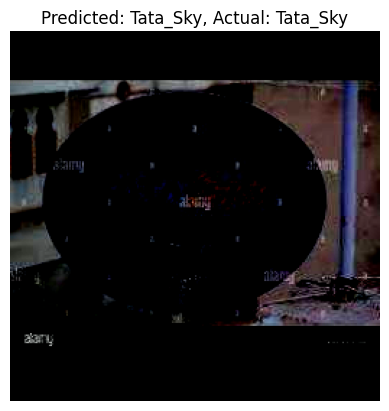

In [32]:
show_random_predictions(model, normalized_dataset, class_names, device, num_samples=5)